In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema
import sys
sys.path.append('../')
import Routines as R

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20,scheduler='slurm',sbatch_options=['--partition=all12h'])

Initialize a parallel Yambo calculator with scheduler direct


In [5]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 #fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

# RT analysis of GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of a single transition

We study the behavior of a simulation in which there is a single $k$ point (using the nosym option).

We select a $k$-point with valence conduction gap of 1.5 eV, for this point the three conduction bands
are not degenerate and thus we can isolate the 4,5 transition. This situation should be described by
the physics of a standard TLS (with the only difference provided by the spin degeneration that brings
a factor 2 in the number of carriers)

In [6]:
simulations = {
    'k1_low': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_hi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 2e5,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
}

### Construction of the SAVE folder and FixSymm procedure

In [7]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_low sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2 sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_hi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [8]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [9]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_nosym'])

In [10]:
for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [4,5]:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

run the computation for k1_low
Skip the run of eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_pi
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
Job completed

run the computation for k1_pi2
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
Job completed

run the computation for k1_hi
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_200000.0-sim_time_500
Job completed



In [59]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi'])

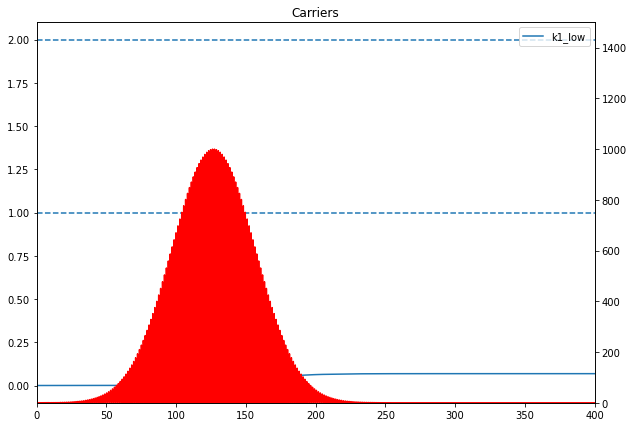

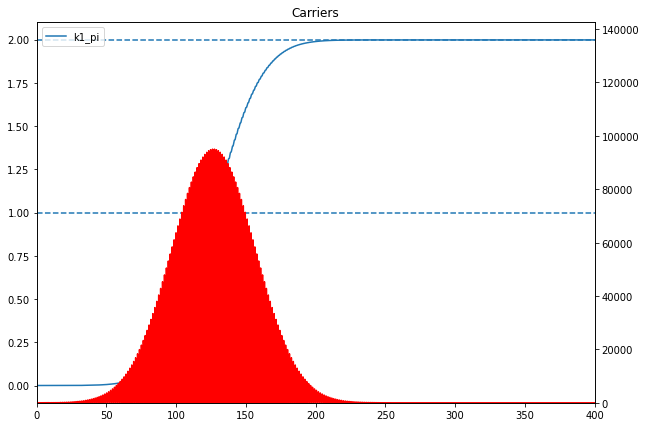

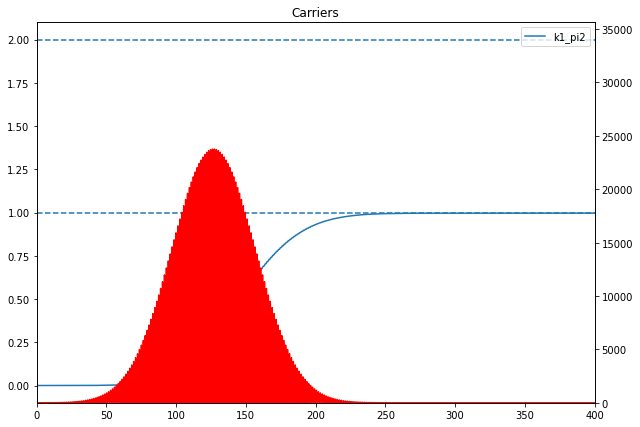

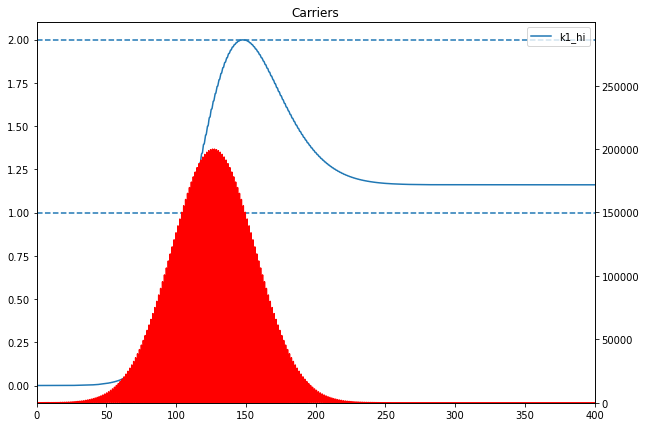

In [12]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax2 = ax.twinx()
    field = val['results']['external_field']
    inte = field['Intensity']
    ax2.plot(time,inte,label=study,c='red')
    ax2.set_ylim(0,1.5*max(inte))
    ax.set_title('Carriers')
    ax.legend(loc='best')
    plt.show()

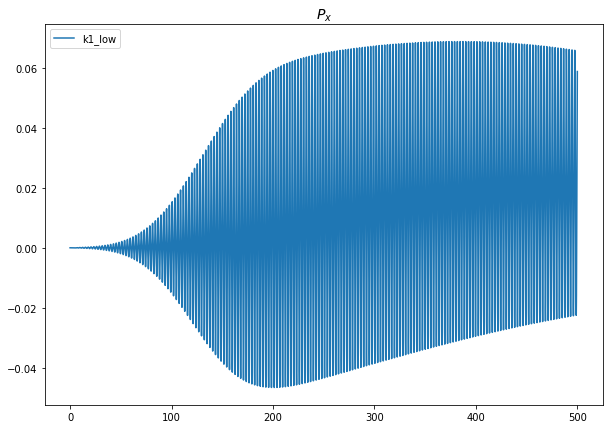

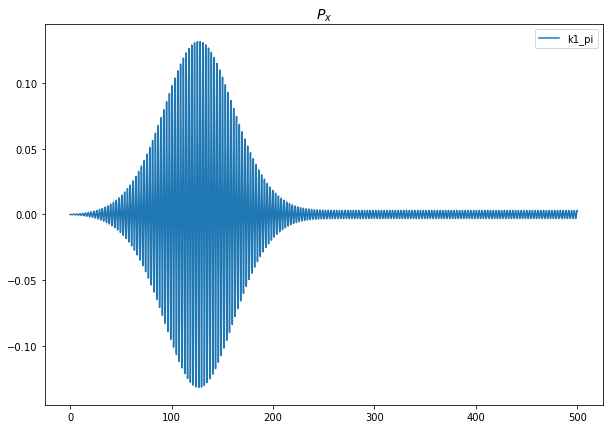

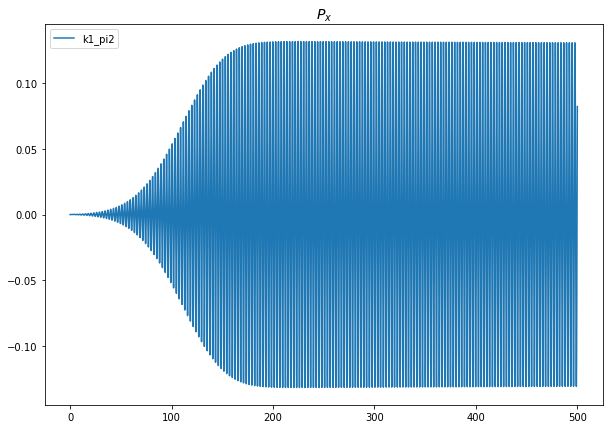

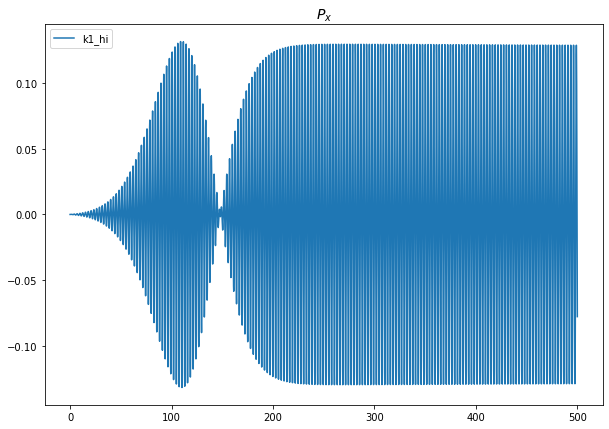

In [13]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

In [12]:
ndb_path = simulations['k1_low']['ndb'] # use this ndb that contain all the transitions
ndb = os.path.join(ndb_path,'ndb.dipoles')
width = 42.46609 # the field width in fs
pump_energy = 1.5 # eV
save = os.path.join(simulations['k1_low']['rt_run_dir'],'SAVE')

In [13]:
dipv1c = R.eval_transition_dipole(ndb,transition=[0,3])
dipv2c = R.eval_transition_dipole(ndb,transition=[1,3])
dipv3c = R.eval_transition_dipole(ndb,transition=[2,3])
print(dipv1c,dipv2c,dipv3c)

9.86059848096699 11.476692102587965 19.401259949136858


In [14]:
trans_energy_v1c = R.eval_trans_energy(save,transition=[1,4],set_scissor=scissor)
trans_energy_v2c = R.eval_trans_energy(save,transition=[2,4],set_scissor=scissor)
trans_energy_v3c = R.eval_trans_energy(save,transition=[3,4],set_scissor=scissor)
print(trans_energy_v1c,trans_energy_v2c,trans_energy_v3c)

1.5831412405008671 1.5026850862673817 1.5000019595177139


In [16]:
R.eval_effective_field_int(width,pump_energy,trans_energy_v3c,verbose=True)

energy resolution in meV 0.4869386916592096
maximum energy 20.677851541308335
number of points of the FT 84932
match with the trans_energy at 1.5002581090020248
scale 1.0


1.0

In [17]:
field_int = 23758

In [18]:
R.eval_pulse_area_single_trans(dipv3c,trans_energy_v3c,field_int,width,pump_energy)

(14.756573102057459, 1.5707885381639304)

In [19]:
R.eval_pulse_area_single_trans(dipv2c,trans_energy_v2c,field_int,width,pump_energy)

(8.60299890150234, 0.9157608595746812)

In [20]:
R.eval_pulse_area_single_trans(dipv1c,trans_energy_v1c,field_int,width,pump_energy)

(0.005326095574842622, 0.0005669453079835963)

## Double gaussian pulse for a single transition

We test the behavior of the single transition under the double gaussian pulse configuration

In [54]:
pulse_energy = 1.5 # eV
T_pulse = U.Planck_ev_ps*1e3/pulse_energy # in fs
T_pulse
T_delay = T_pulse* 363
T_delay

1000.831582432

In [55]:
simulations = {
    'echo_pi2-pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym/',
        'field_pol' : 'linear',
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 23758, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'echo_pi2-pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym/',
        'field_pol' : 'linear',
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [56]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for echo_pi2-pi2 sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym/. No operations performed.
 
build SAVE for echo_pi2-pi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym/. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [57]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for ind,f in pars['fields'].items():
        rt_input.set_rt_field(index=ind,int=f['int'],width=f['width'],polarization=pars['field_pol'],freq=f['eng'],tstart=f['tstart'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [58]:
sel_sim = simulations

In [59]:
for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    name = sim
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

run the computation for echo_pi2-pi2
run 0 command: cd RT_singlek1.5_nosym/; mpirun -np 4 yambo_rt -F echo_pi2-pi2.in -J echo_pi2-pi2 -C echo_pi2-pi2
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed

run the computation for echo_pi2-pi
Skip the run of echo_pi2-pi
Job completed



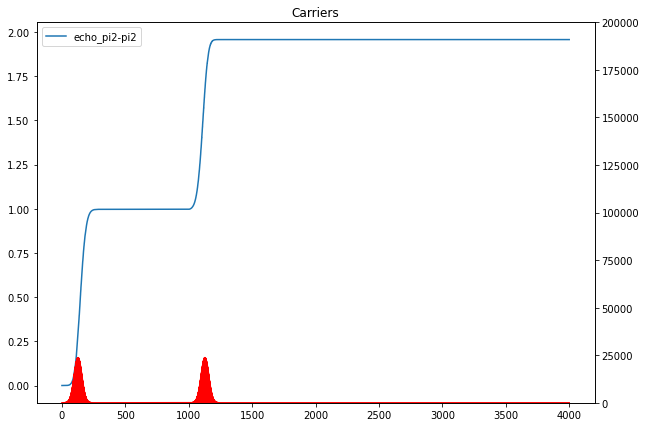

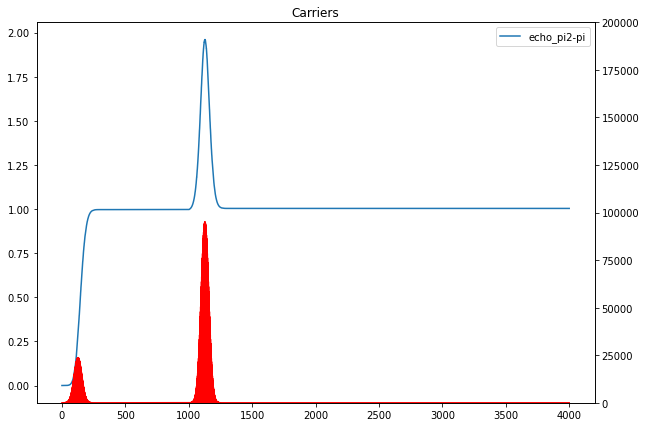

In [66]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax2 = ax.twinx()
    field = val['results']['external_field']
    inte = field['Intensity']
    ax2.plot(time,inte,label=study,c='red')
    ax2.set_ylim(0,2e5)
    ax.set_title('Carriers')
    ax.legend(loc='best')
    plt.show()

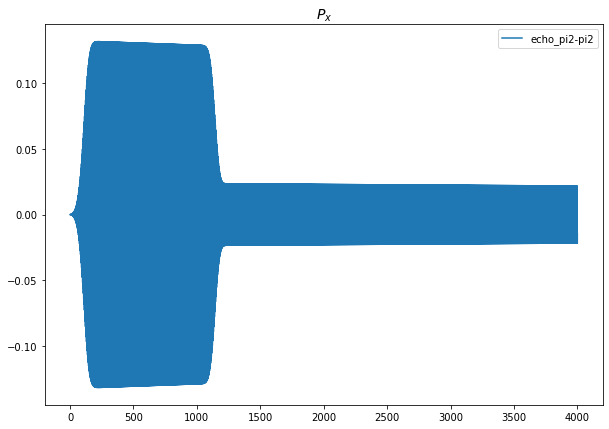

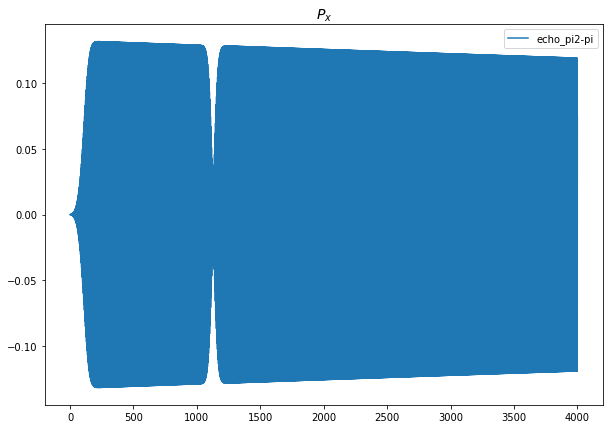

In [64]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

The polarization for the echo_pi2-pi2 case is not exactly as the one in the TLS, since
for T>1000 we expect a vanishing result, check!

## Single transition with a $\delta$ of 31.1 meV

We consider a second k point and analyze the dynamics due to a single transition. In this 
case the transition is not resonant with the pump and a $\delta$ of 31.1 meV is present

In [14]:
simulations = {
    'k1_pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_delta_31meV.save',
        'run_dir' : 'RT_singlek_delta31_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_delta_31meV.save',
        'run_dir' : 'RT_singlek_delta31_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [15]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_pi sim with the -nosym option
Create folder RT_singlek_delta31_nosym
Executing command: cd NSCF/bnds_8-sampling_delta_31meV.save; p2y -nosym
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-sampling_delta_31meV.save/SAVE in RT_singlek_delta31_nosym
Executing command: cd RT_singlek_delta31_nosym;OMP_NUM_THREADS=1 yambo
 
build SAVE for k1_pi2 sim with the -nosym option
SAVE folder already present in RT_singlek_delta31_nosym. No operations performed.
 
mv RT_singlek_delta31_nosym/SAVE/ns.kb_pp_pwscf RT_singlek_delta31_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek_delta31_nosym/SAVE/ns.kb_pp_pwscf RT_singlek_delta31_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [16]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [17]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_nosym'])

In [18]:
for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [4,5]:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

run the computation for k1_pi
run 0 command: cd RT_singlek_delta31_nosym; mpirun -np 4 yambo_rt -F bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500.in -J bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500 -C bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
run0_is_running: True 
Job completed

run the computation for k1_pi2
run 0 command: cd RT_singlek_delta31_nosym; mpirun -np 4 yambo_rt -F bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500.in -J bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500 -C bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
run0_is_running: True 
Job completed



In [19]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi'])

In [26]:
def single_pulse(t,A,width):
    t0 = 3*width
    return A*np.exp(-(t-t0)**2/(2.*width**2))


18921366.71472994


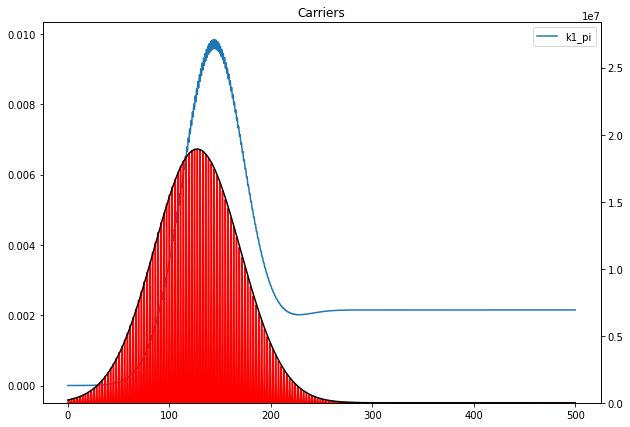


9460633.581454257


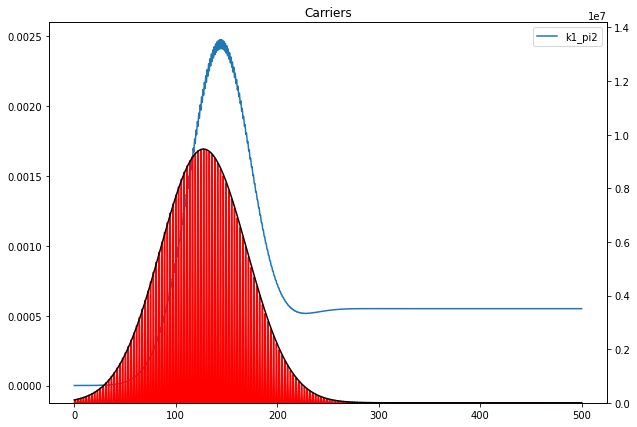

In [31]:
for study,val in sel_sim.items():
    print()
    fig, ax = plt.subplots(figsize=(10, 7))
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    #ax.set_xlim(0,400)
    ax2 = ax.twinx()
    field = val['results']['external_field']
    ex = field['Ex_Re']
    ax2.plot(time,ex,label=study,c='red')
    ax2.set_ylim(0,1.5*max(ex))
    
    Z0 = U.vacuum_impedence
    field_int = val['field_int']*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    print(field_amp)
    sp = single_pulse(time,field_amp,42.466)
    ax2.plot(time,sp,c='black')
    
    ax.set_title('Carriers')
    ax.legend(loc='best')
    plt.show()

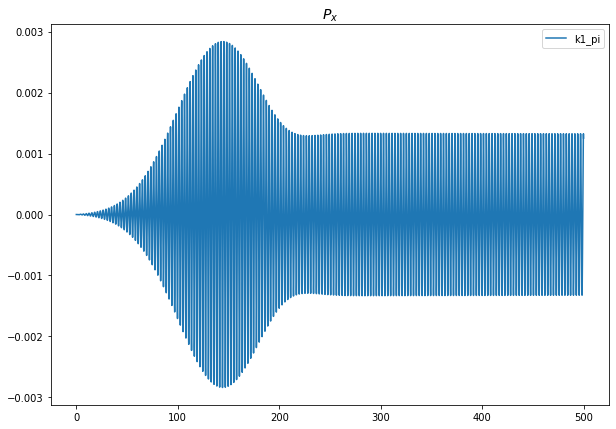

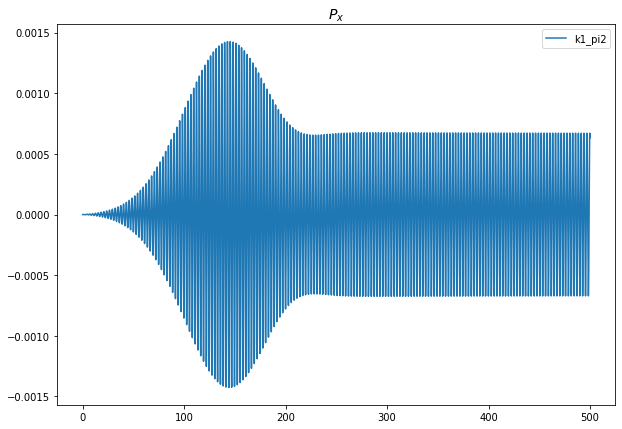

In [22]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

There is a relevant difference between the Yambo results and the TLS ones!

## Multi $k$ analysis - Single gaussian pulse. Analysis of FID

In [78]:
simulations = {
    'pi2': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'pi2_single-trans': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5],
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [79]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for pi2
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for pi2_single-trans
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [80]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [81]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [82]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['low_pulse','pi2'])

In [ ]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

In [15]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

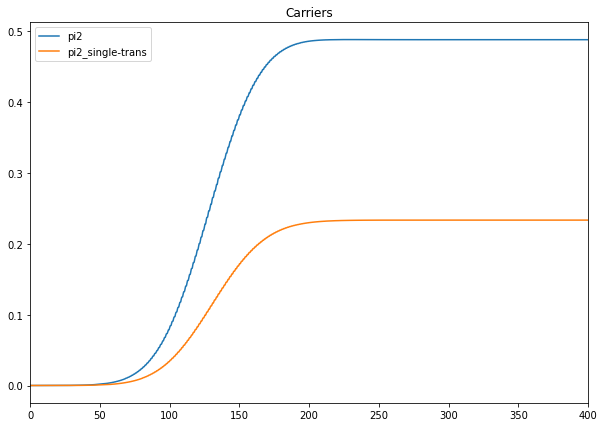

In [84]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

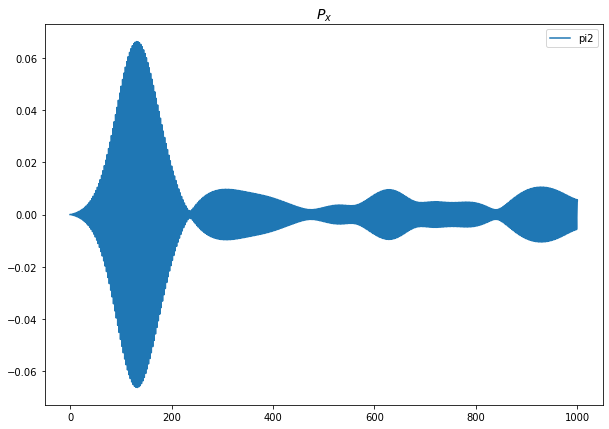

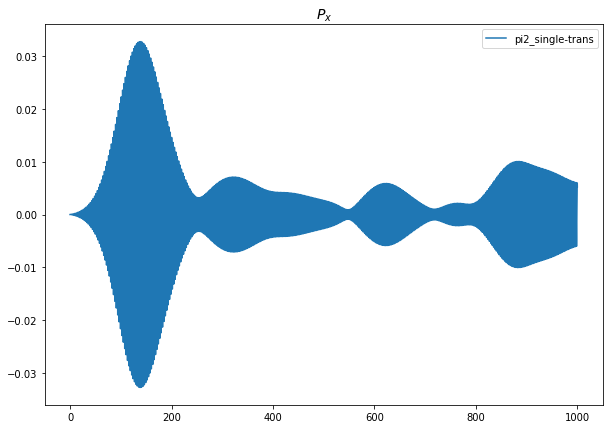

In [85]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Multi $k$ analysis - Double gaussian pulse for echo mechanism

We build of the dictionary with the parameters of the various simulations.

In [67]:
pulse_energy = 1.5 # eV
T_pulse = U.Planck_ev_ps*1e3/pulse_energy # in fs
T_pulse
T_delay = T_pulse* 363
T_delay

1000.831582432

In [68]:
simulations = {
    'echo_pi2-pi': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'echo_pi2-pi_single-trans': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }    
}

### Construction of the SAVE folder and FixSymm procedure

In [69]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo_pi2-pi
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo_pi2-pi_single-trans
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [70]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for ind,f in pars['fields'].items():
        rt_input.set_rt_field(index=ind,int=f['int'],width=f['width'],polarization=pars['field_pol'],freq=f['eng'],tstart=f['tstart'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [71]:
sel_sim = simulations

In [ ]:
for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    name = sim
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

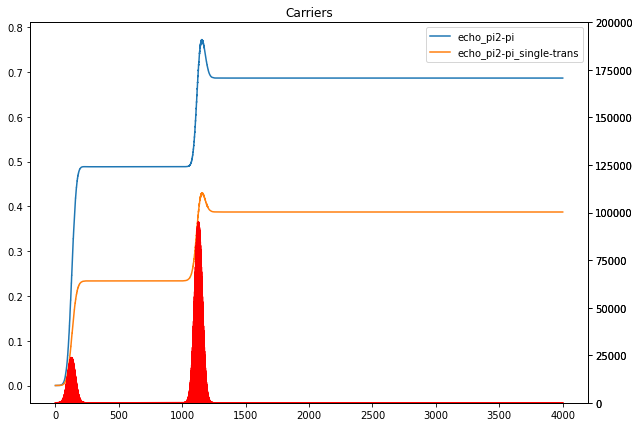

In [75]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax2 = ax.twinx()
    field = val['results']['external_field']
    inte = field['Intensity']
    ax2.plot(time,inte,label=study,c='red')
    ax2.set_ylim(0,2e5)
    ax.set_title('Carriers')
    ax.legend(loc='best')

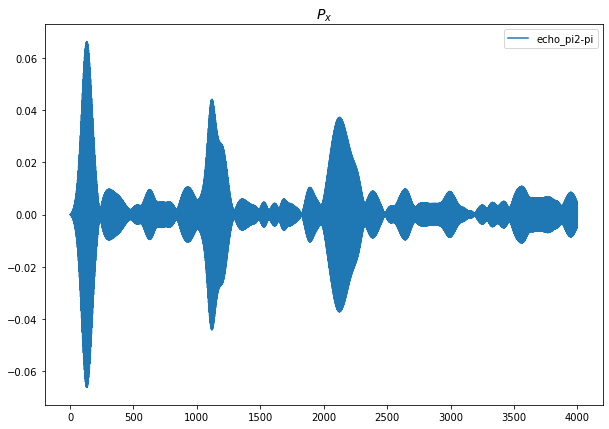

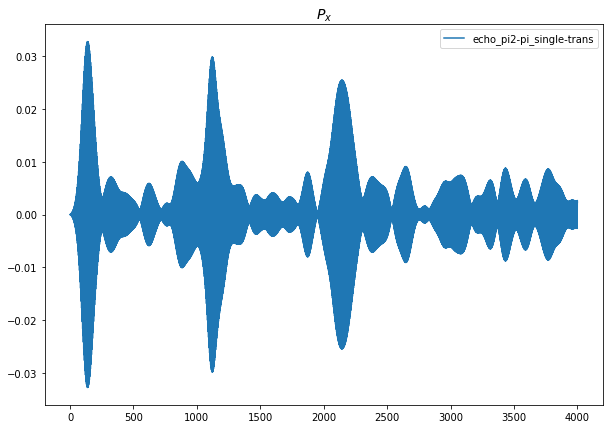

In [76]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

In [ ]:
#################################################################################

## Analysis of a single $k$-point (with multiple transitions)

We analyze the same simulations performed before removing the option that selects
only a single transition

In [142]:
simulations = {
    'k1_low': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi_eff': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 72000,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi2_eff': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 18000,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_hi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 2e5,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi2_extrans': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [2,6]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [143]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_low sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi_eff sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2 sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2_eff sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_hi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2_extrans sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv 

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [144]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [145]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [146]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi2_nosym']) #k1_singletrans'])

In [147]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [2,6]:
        idd['bands'] = 'ext-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_low
Skip the run of eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_pi
Skip the run of eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
Job completed

run the computation for k1_pi_eff
run 0 command: cd RT_singlek1.5_nosym; mpirun -np 4 yambo_rt -F eta_1e-05-field_eng_1.5-field_int_72000-sim_time_500.in -J eta_1e-05-field_eng_1.5-field_int_72000-sim_time_500 -C eta_1e-05-field_eng_1.5-field_int_72000-sim_time_500
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed

run the computation for k1_pi2
Skip the run of eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
Job completed

run the computation for k1_pi2_eff
Skip the run of eta_1e-05-field_eng_1.5-field_int_18000-sim_time_500
Job completed

run the computation for k1_hi
Ski

In [148]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi2_nosym','k1_pi2_nosym_extrans'])

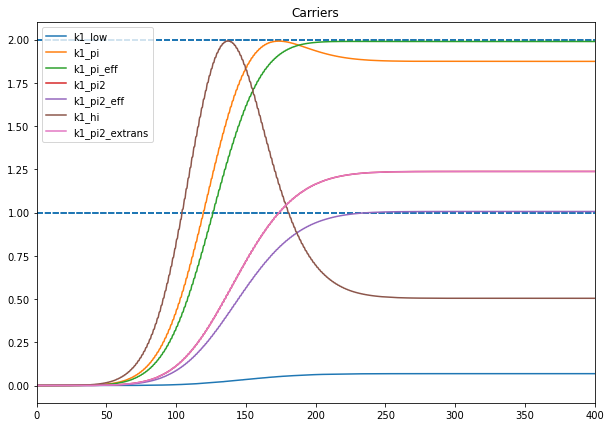

In [149]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

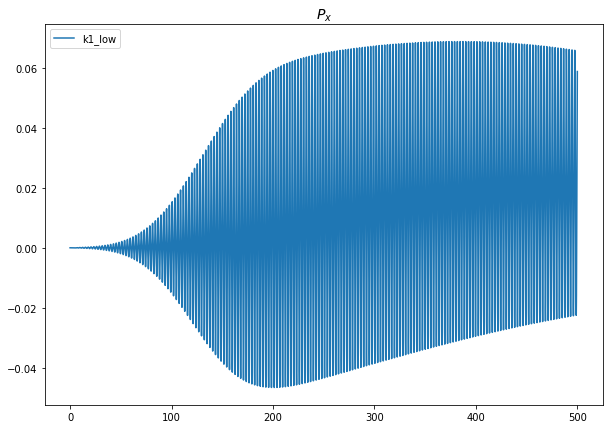

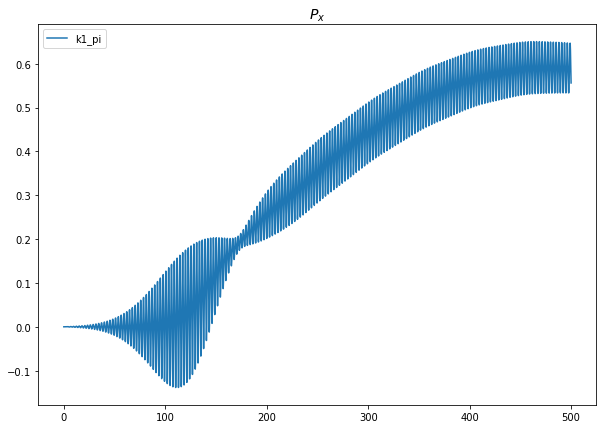

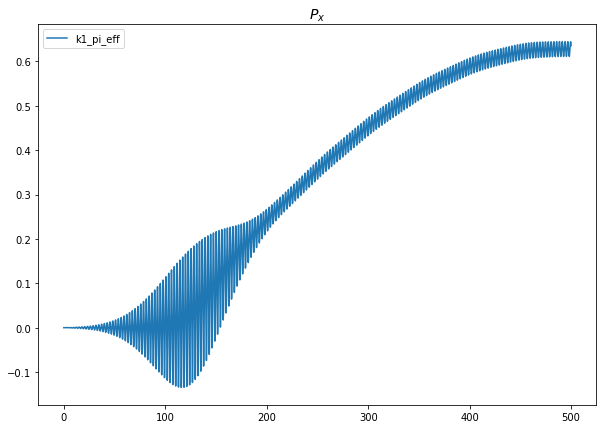

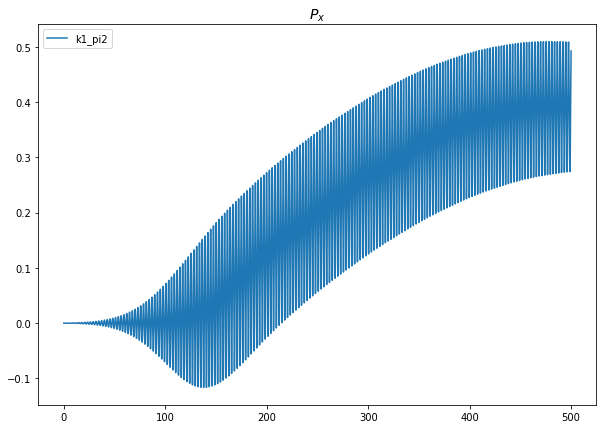

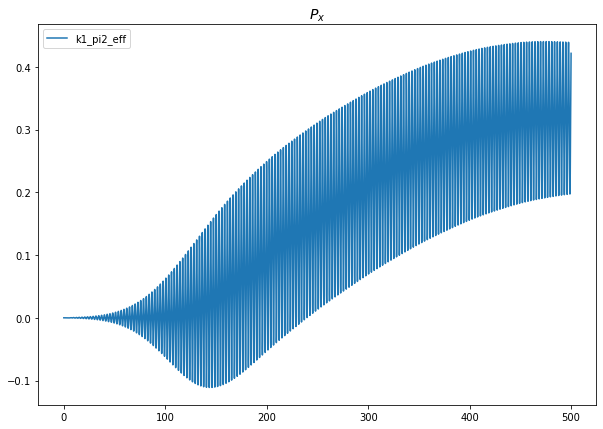

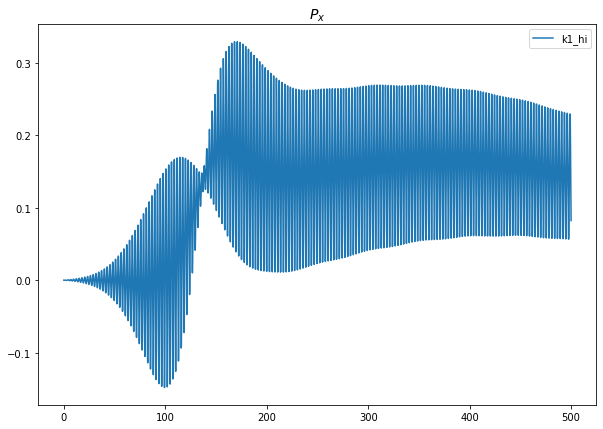

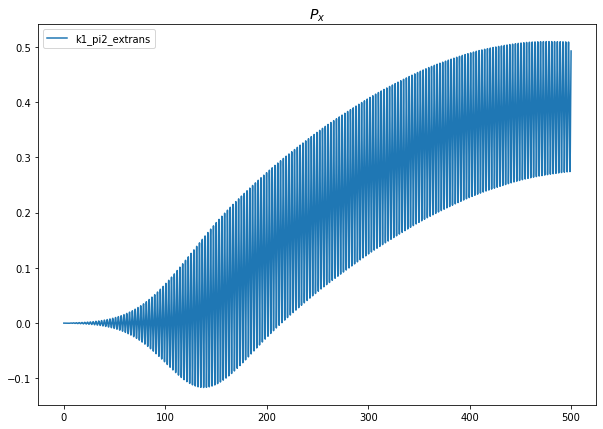

In [150]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Analysis of a single $k$-point without -nosym option (with multiple transitions)

We look for the $\pi/2$ and $\pi$ configuration when the all the symmetry related points are considered. 
To realize the wanted conditions a small refinement w.r.t the case with -nosym is needed. 

In [4]:
simulations = {
    'k1_low': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'k1_pi_eff': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5',
        'field_int' : 72000,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'k1_pi2_eff': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5',
        'field_int' : 19000,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [5]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for k1_low
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1_pi_eff
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1_pi2_eff
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [6]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [7]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [8]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi2_nosym']) #k1_singletrans'])

In [219]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [2,6]:
        idd['bands'] = 'ext-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_low
Skip the run of eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_pi_eff
Skip the run of eta_1e-05-field_eng_1.5-field_int_72000-sim_time_500
Job completed

run the computation for k1_pi2_eff
Skip the run of eta_1e-05-field_eng_1.5-field_int_19000-sim_time_500
Job completed



In [220]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi2_nosym','k1_pi2_nosym_extrans'])

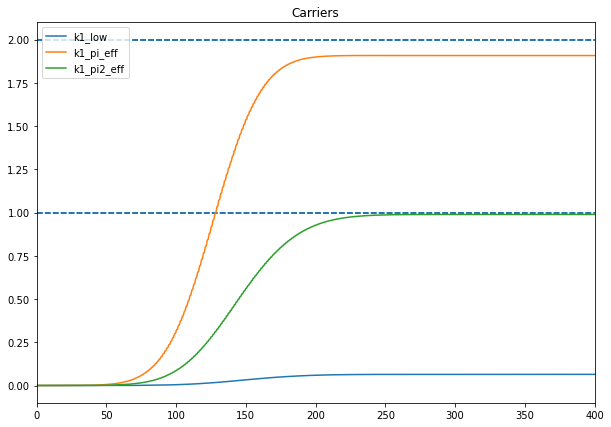

In [221]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

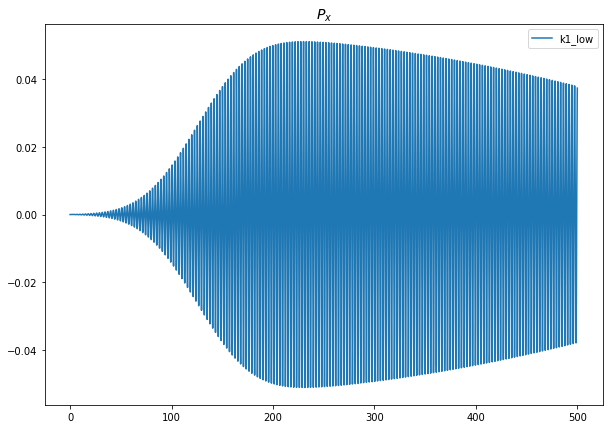

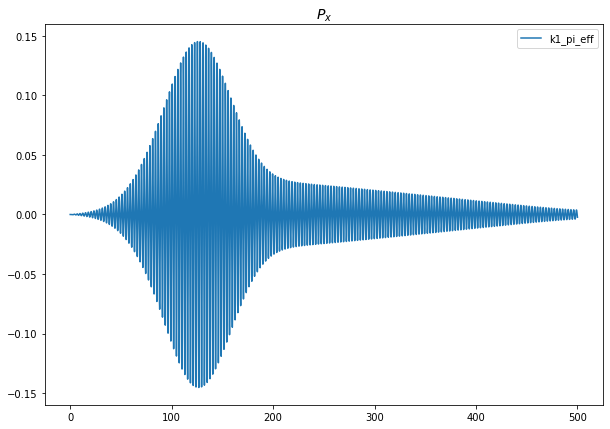

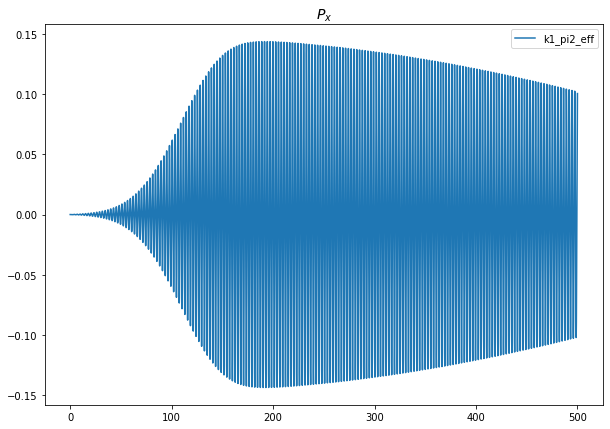

In [222]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Analysis at $\Gamma$ point

We perform the simulations at $\Gamma$ where the multiple transitions cannot be isolated due to the
degeneracy of the bands.

In [78]:
simulations = {
    'gamma': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma',
        'field_int' : 2644.21,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma',
        'field_int' : 0,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [79]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for gamma
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_pi2
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_pi
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [80]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [81]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [82]:
#sel_sim = simulations
sel_sim = dict((k,simulations[k]) for k in ['gamma','gamma_pi2'])

In [83]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [2,6]:
        idd['bands'] = 'ext-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for gamma
Skip the run of eta_1e-05-field_eng_1.42-field_int_1000.0-sim_time_500
Job completed

run the computation for gamma_pi2
Skip the run of eta_1e-05-field_eng_1.42-field_int_2644.21-sim_time_500
Job completed



In [84]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi2_nosym','k1_pi2_nosym_extrans'])

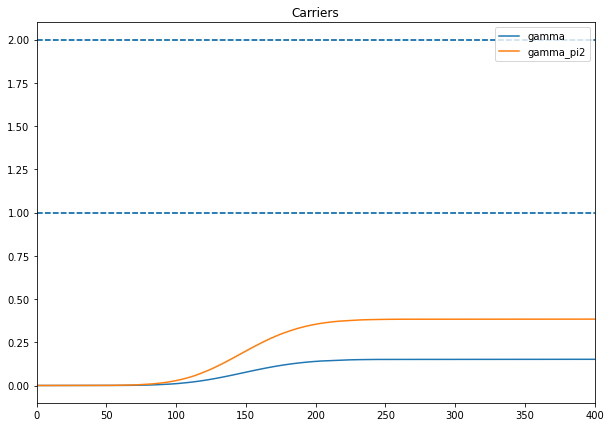

In [85]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

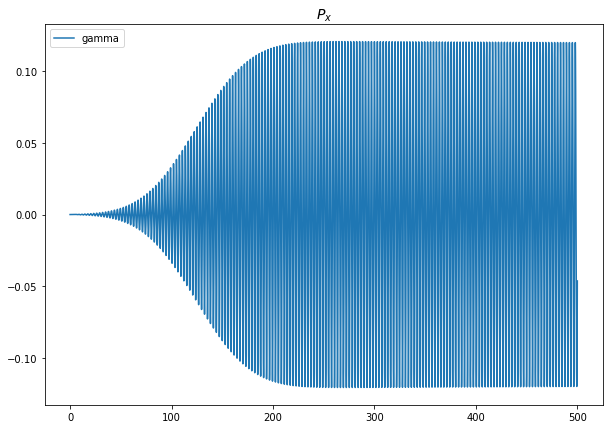

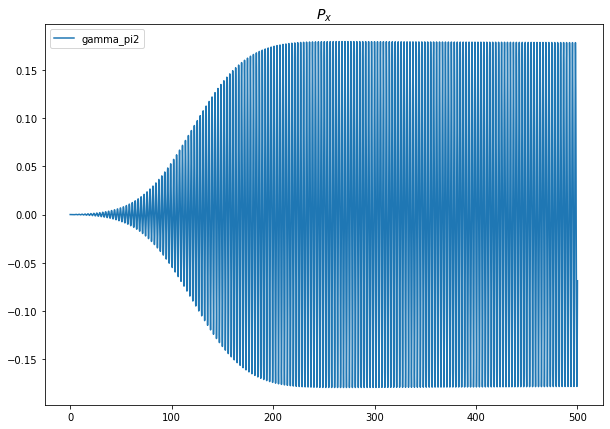

In [86]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

We use the routines to compute the field intensity that produce the $\pi/2$ or the $\pi$
condition

In [87]:
ndb_path = simulations['gamma']['ndb']
width = 42.46609 # the field width in fs

In [90]:
field_int = 1000
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width,transitions=[[0,3]])
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width,transitions=[[1,3]])
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width,transitions=[[2,3]])

coupling frequency (THz): 3.20552451603674
pulse area : 0.34121751261422273
coupling frequency (THz): 3.1064229525711826
pulse area : 0.33066847802948446
coupling frequency (THz): 2.7629101814823973
pulse area : 0.2941026764841405


(2.7629101814823973, 0.2941026764841405)

we observe that the three valence bands contribute in a similar way.

Again if we forsee the value of the intensity using the sum of the transitions we obtain a wrong result

In [91]:
theta = 0.5*np.pi
eval_field_intensity(os.path.join(ndb_path,'ndb.dipoles'),theta,width,transitions=[[0,3],[1,3],[2,3]])

field intensity (kW/cm^2) : 2644.208465857056


2644.208465857056

We see that the evaluation of $\Theta$ performed with the sum of the dipoles does not produce the expected
result, probably this is due to the fact that the various TLS are coupled by the single conduction band.

## Multi $k$ analysis - Single gaussian pulse

We build of the dictionary with the parameters of the various simulations.

In [9]:
simulations = {
    'low_pulse': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'pi2': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 19000,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'pi': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 72000,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [10]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for low_pulse
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for pi2
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for pi
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [11]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [12]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [16]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['low_pulse','pi2'])

In [ ]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

In [15]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

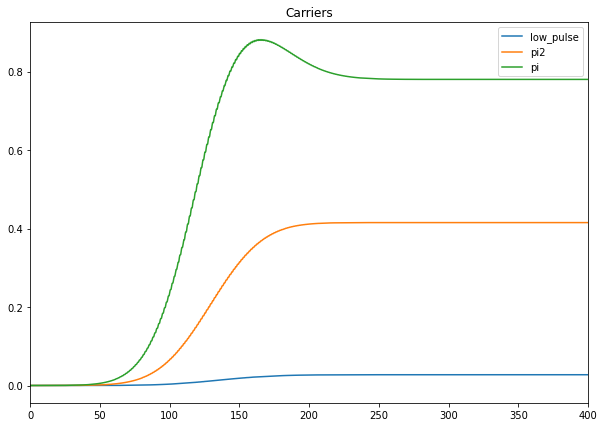

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

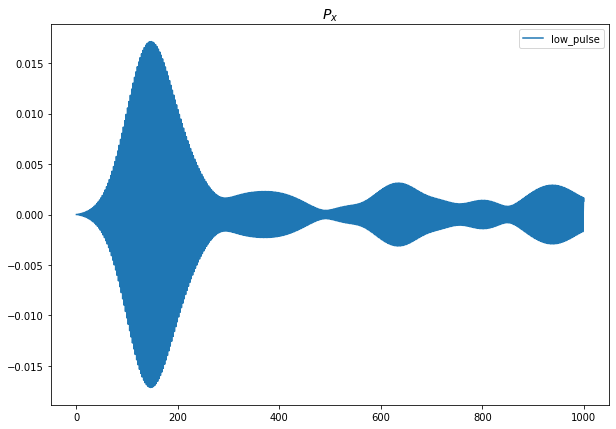

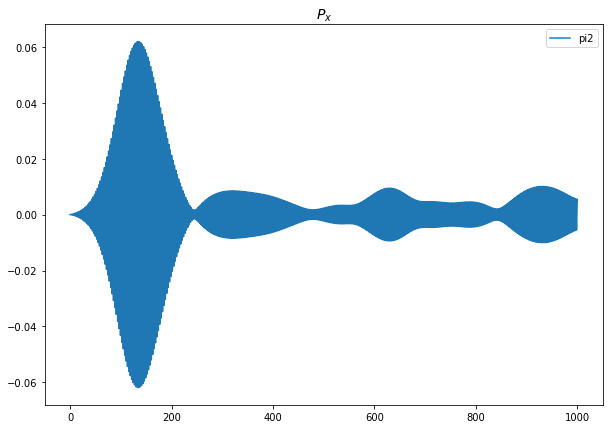

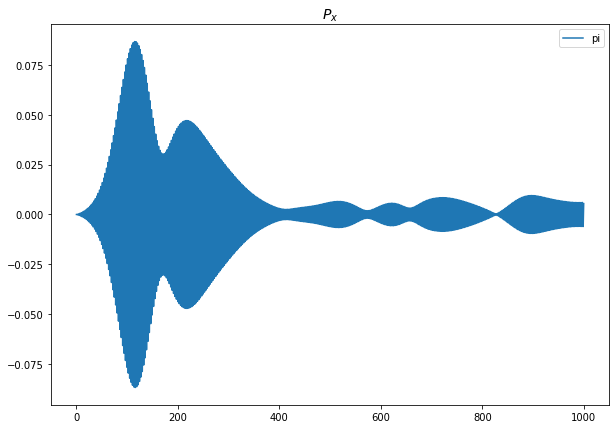

In [19]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

In [249]:
ndb_path = simulations['low_pulse']['ndb'] # use this ndb that contain all the transitions
ndb = os.path.join(ndb_path,'ndb.dipoles')
width = 42.46609 # the field width in fs
field_int = 19000
pump_energy = 1.5 # eV
save = os.path.join(simulations['low_pulse']['rt_run_dir'],'SAVE')

In [254]:
kpoint = 0 # up to 1182

In [ ]:
coupl_freqs = []
thetas = []
for k in range(1182):
    dip_mod = R.eval_transition_dipole(ndb,kpoint=k,transition=[2,3])
    trans_energy_v3c = trans_energy_v3c = R.eval_trans_energy(save,kpoint=k,transition=[3,4],set_scissor=scissor)
    coupl_freq,theta = R.eval_pulse_area_single_trans(dip_mod,trans_energy,field_int,width,pump_energy)
    coupl_freqs.append(coupl_freq)
    thetas.append(theta)

In [269]:
thetas = np.array(thetas)

In [271]:
sum(thetas)/len(thetas)

1.0300771966201832

In [272]:
dos = U.Dos()

In [273]:
dos.append(np.array(thetas))

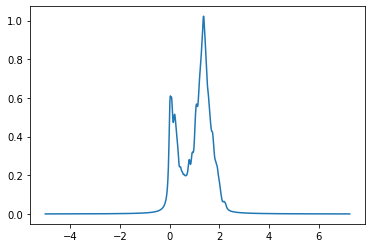

In [274]:
dos.plot(plt)

## Multi $k$ analysis - Double gaussian pulse for echo mechanism

We build of the dictionary with the parameters of the various simulations.

In [4]:
simulations = {
    'echo1': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym/',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : 1000}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'echo4': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : 1000}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'echo5': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : 1000}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'echo6': {
        'source_dir' : 'NSCF/bnds_8-kpoints_200-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k200_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : 1000}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [14]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for echo1 sim with the -nosym option
Executing command: cd NSCF/bnds_8-sampling_resonant_1.5eV.save; p2y -nosym
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-sampling_resonant_1.5eV.save/SAVE in RT_singlek1.5_nosym/
Executing command: cd RT_singlek1.5_nosym/;OMP_NUM_THREADS=1 yambo
 
build SAVE and perform FixSymm for echo4
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo5
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo6
SAVE folder already present in RT_k200_kspan0.04. No operations performed.
FixSymm folder RT_k200_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_singlek1.5

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [15]:
# Common parameters (eventually overwritten by the dictionary values)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [16]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for ind,f in pars['fields'].items():
        rt_input.set_rt_field(index=ind,int=f['int'],width=f['width'],polarization=pars['field_pol'],freq=f['eng'],tstart=f['tstart'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [17]:
#sel_sim = simulations
sel_sim = dict((k,simulations[k]) for k in ['echo1'])

In [18]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20,scheduler='slurm',,sbatch_options=['--partition=all12h'])

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    #idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    #if pars.get('Gauge') is not None:
    #    idd['gauge'] = pars['Gauge']
    #if pars.get('bands') is not None:
    #    idd['bands'] = 'single-trans'
    #name = D.name_from_id(idd)
    name = sim
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for echo1
run 0 command: cd RT_singlek1.5_nosym/; mpirun -np 4 yambo_rt -F echo1.in -J echo1 -C echo1
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_runn

In [28]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

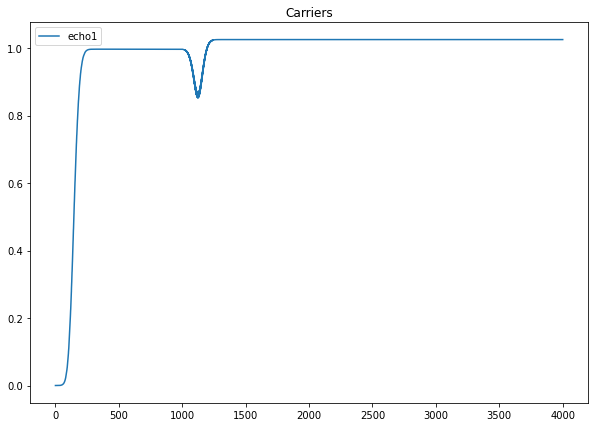

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    #ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

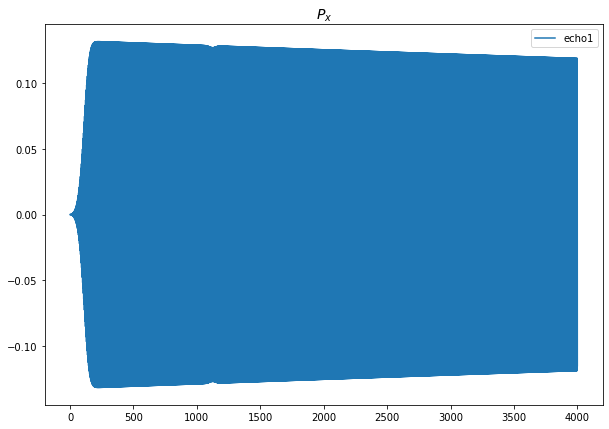

In [20]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()